# Project: Life Expectancy and GDP

By Tomahawk Jupiter Dec 2023.

This is my project for The Open University's [_Learn to code for Data Analysis_ ](https://www.open.edu/openlearn/digital-computing/learn-code-data-analysis/content-section-overview?active-tab=description-tab) course.

## Introduction

I am going to use the data from the [World Bank](https://data.worldbank.org/) to answer some questions. I'm going to look at GDP, life expectancy and total population to answer some questions.

### Questions

#### Answer one or more of the following questions:

1. To what extent do the ten countries with the highest GDP coincide with the ten countries with the longest life expectancy?

2. Which are the two countries in the right half of the plot (higher GDP) with life expectancy below 60 years? What factors could explain their lower life expectancy compared to countries with similar GDP?

    Hint: use the filtering techniques you learned in Week 2 to find the two countries.
  
3. Redo the analysis using the countries’ GDP per capita (i.e. per inhabitant) instead of their total GDP. If you’ve done the workbook exercises, you already have a column with the population data.

    Hint: write an expression involving the GDP and population columns, as you learned in Calculating over columns  in Week 1.

4. Redo the analysis using the indicator suggested at the end of the project notebook.

## Gathering the Data

All the data comes from [wolrdbank.org](https://data.worldbank.org/) where you can download datasets for free.

Datasets:

- [GDP](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2022&start=1960&view=chart)
- [Life Expectancy](https://data.worldbank.org/indicator/SP.DYN.LE00.IN)
- [Total Population](https://data.worldbank.org/indicator/SP.POP.TOTL?end=2022&start=1960&view=chart)

NOTE: I'm going to use historic data provided by openLearn as I'm just learning/practising ([Course resources](https://www.open.edu/openlearn/digital-computing/learn-code-data-analysis/content-section-overview?active-tab=content-tab)).

In [1]:
import pandas as pd
print(pd.__version__) # I like to check it worked

1.4.4


In [2]:
gdp = pd.read_csv('./wb_gdp_2013.csv')
life = pd.read_csv('./wb_le_2013.csv')
pop = pd.read_csv('./wb_pop_2013.csv')

# Constants shouldn't be overwritten
# Use variables for column names
COUNTRY = 'country'
YEAR = 'year'
GDP_INDICATOR = 'NY.GDP.MKTP.CD'
LIFE_INDICATOR = 'SP.DYN.LE00.IN'
POP_INDICATOR = 'SP.POP.TOTL'


## Cleaning the Data

NOTE: The lesson for this process is in `part3.ipynb`.

### Remove year column

All data is from the same year so I don't need those columns.

In [3]:
gdp.drop(YEAR, axis=1, inplace=True)
life.drop(YEAR, axis=1, inplace=True)
pop.drop(YEAR, axis=1, inplace=True)

### Join Tables

I join the three tables into a single one. First I check how many rows there are in each table so that after the join I can see if anything was lost, nothing should be lost because I'm joining on country name.

In [4]:
def print_row_count(frame):
  print(f"There are {len(frame)} rows.")

print_row_count(gdp)
print_row_count(life)
print_row_count(pop)

There are 248 rows.
There are 248 rows.
There are 248 rows.


In [5]:
all = pd.merge(gdp, life, on=COUNTRY, how='inner')
all = pd.merge(all, pop, on=COUNTRY, how='inner')


In [6]:
all.shape

(248, 4)

### Remove the grouped country rows

There are rows of data for groups of countries before the individual countries that I remove. The first country in the table should be Afghanistan after I remove the rows.

I store the grouped country rows in case I want to look at them later.

In [7]:
grouped_countries = all[:34]
all = all[34:]
all.head(1)

,country,NY.GDP.MKTP.CD,SP.DYN.LE00.IN,SP.POP.TOTL
34,Afghanistan,2.045894e+10,60.028268,30682500.0


### Handle null data

I will look for missing data and remove those rows. There are 38 null values, so I will lose at most that many rows (its possible a single row might contain more than one null value).

I store the removed rows in another dataFrame in case I need them later.

In [8]:
all.isna().sum()

country            0
NY.GDP.MKTP.CD    22
SP.DYN.LE00.IN    16
SP.POP.TOTL        0
dtype: int64

In [9]:
removed_rows = all[all.isnull().any(axis=1)]
len_before = len(all)
all.dropna(inplace=True)
print(f"Rows removed: { len(removed_rows)}")

Rows removed: 28


### Functions to help transform data

I want the GDP to be measured in pounds sterling (£) and in units of one million. I will make a new column for these computed values. I will then drop the original row.

Then I will round the life expectancy to whole numbers.

In [10]:
def roundToMillions (value):
  result = round(value / 1_000_000)
  return result

def usdToGbp (usd):
  return usd / 1.564768 # average rate during 2013

GDP = 'GDP (£m)'
all[GDP] = all[GDP_INDICATOR].apply(usdToGbp).apply(roundToMillions)
all.drop(GDP_INDICATOR, axis=1, inplace=True)

Finally I change the units used to measure population to millions, remembering to change the column name to show this. I may need to change how many places I round to later.

In [11]:
def populationToMillions (value):
  result = round(value / 1_000_000, 2)
  return result

all[POP_INDICATOR] = all[POP_INDICATOR].apply(populationToMillions)
POP = 'Population (millions)'
all.rename(columns={POP_INDICATOR: POP}, inplace=True)

In [12]:
all.head()

,country,SP.DYN.LE00.IN,Population (millions),GDP (£m)
34,Afghanistan,60.028268,30.68,13075
35,Albania,77.537244,2.90,8168
36,Algeria,74.568951,38.19,134016
39,Angola,51.866171,23.45,88420
40,Antigua and Barbuda,75.778659,0.09,767


### Rename Columns

The original column names are a bit hard to understand, I'll name them something clearer.

In [13]:
LIFE = 'Life Expectancy'
all.rename(columns={LIFE_INDICATOR: LIFE}, inplace=True)

all.head(1)

,country,Life Expectancy,Population (millions),GDP (£m)
34,Afghanistan,60.028268,30.68,13075


### Round life expectancy whole number

In [14]:
all[LIFE] = all[LIFE].apply(round)
all.head(3)

,country,Life Expectancy,Population (millions),GDP (£m)
34,Afghanistan,60,30.68,13075
35,Albania,78,2.90,8168
36,Algeria,75,38.19,134016


## Answering Quesions

### What country has the highest and lowest value for each column?

In [15]:
def show_max_and_min(df, column):
  print(f"Max in {column}:\n")
  print(df.loc[df[column].idxmax()][[COUNTRY, column]])
  print(f"\nMin in {column}:\n")
  print(df.loc[df[column].idxmin()][[COUNTRY, column]])

show_max_and_min(all, POP)

Max in Population (millions):

country                    China
Population (millions)    1357.38
Name: 74, dtype: object

Min in Population (millions):

country                  Faeroe Islands
Population (millions)              0.05
Name: 97, dtype: object


In [16]:
show_max_and_min(all, LIFE)

Max in Life Expectancy:

country            Hong Kong SAR, China
Life Expectancy                      84
Name: 117, dtype: object

Min in Life Expectancy:

country            Lesotho
Life Expectancy         49
Name: 142, dtype: object


In [17]:
show_max_and_min(all, GDP)


Max in GDP (£m):

country     United States
GDP (£m)         10715999
Name: 237, dtype: object

Min in GDP (£m):

country     Kiribati
GDP (£m)         108
Name: 133, dtype: object


### Q1. To what extent do the ten countries with the highest GDP coincide with the ten countries with the longest life expectancy?

I slice the top ten countries for GDP and life expectancy. Then I do an inner join, this will show me countries that appear in both slices.

There are just two countries in this table, Japan and France out of a possible maximum of ten.

In [18]:
gdp_desc = all.sort_values(by=GDP, ascending=False)[:10]
life_desc = all.sort_values(by=LIFE, ascending=False)[:10]

table_overlap = pd.merge(gdp_desc, life_desc, on=COUNTRY, how='inner', suffixes=(None, '_dup'))
table_overlap

,country,Life Expectancy,Population (millions),GDP (£m),Life Expectancy_dup,Population (millions)_dup,GDP (£m)_dup
0,Japan,83,127.34,3143957,83,127.34,3143957
1,France,82,65.93,1795953,82,65.93,1795953


#### Spearman rank correlation coefficient

I try to use the `spearmanr` function. I'm not completely sure I'm using it right.

I combine the top 10 for GDP and Life Expectancy tables but this time with an outer join to keep all the countries. Then I fill in the null values with the duplicate column's values, there will be a value for atleast one of them.

Once I have this new table, I can run the relevant columns into the `spearmanr` function to get the correlation and pValue. The value returned is statistically significant, which makes sense as 2 out of the 18 countries are in the top 10 for both (which is 11.11%). This is not a very strong correlation though.

#### Conclusion

There is an overlap of 2 out of a possible 18.

In [19]:
from scipy.stats import spearmanr

top_outer_merge = pd.merge(gdp_desc, life_desc, on=COUNTRY, how='outer', suffixes=(None, '_dup'))

top_outer_merge['Life Expectancy'] = top_outer_merge['Life Expectancy'].combine_first(top_outer_merge['Life Expectancy_dup'])
top_outer_merge['GDP (£m)'] = top_outer_merge['GDP (£m)'].combine_first(top_outer_merge['GDP (£m)_dup'])

top_outer_merge

gdp_col = top_outer_merge[GDP]
life_col = top_outer_merge[LIFE]

(correlation, pValue) = spearmanr(gdp_col, life_col)

print(f"pValue: {pValue}")
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

pValue: 0.03284732607415343
The correlation is -0.5042620998224523
It is statistically significant.


In [20]:
print(gdp_desc)
print(life_desc)

                country  Life Expectancy  Population (millions)  GDP (£m)
237       United States               79                 316.50  10715999
74                China               75                1357.38   6065182
129               Japan               83                 127.34   3143957
105             Germany               81                  80.65   2393529
100              France               82                  65.93   1795953
236      United Kingdom               81                  64.11   1733354
60               Brazil               74                 204.26   1528714
127               Italy               82                  60.23   1363486
191  Russian Federation               71                 143.51   1328647
120               India               68                1279.50   1189826
                  country  Life Expectancy  Population (millions)  GDP (£m)
117  Hong Kong SAR, China               84                   7.19    176220
119               Iceland         

### Q2. Which are the two countries in the right half of the plot (higher GDP) with life expectancy below 60 years? What factors could explain their lower life expectancy compared to countries with similar GDP?

The scatter plot below is what the question is refering to.

<AxesSubplot:xlabel='GDP (£m)', ylabel='Life Expectancy'>

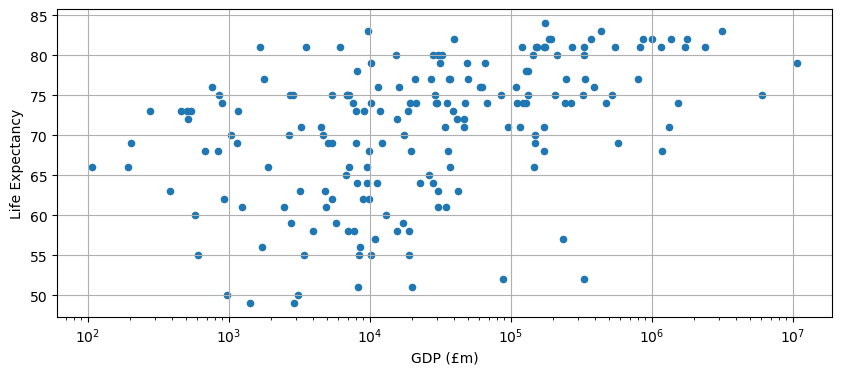

In [21]:
%matplotlib inline

headers = [COUNTRY, GDP, LIFE]
gdp_vs_life = all[headers]
gdp_vs_life.plot(x=GDP, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

To answer this question first I filter out only the life expectancy below 60, then sort descending. The first two countries will be the ones I'm interested in. It gave me **Nigeria** and **South Africa**, both are African countries.

After that I'll look at other countries with a similar GDP so I can compare them to these two. I'll choose a range of 200,000 to 400,000 (in millions).

There are 14 countries meeting those conditions. Out of those 14 only two are in Africa, the ones I found in the first step.

#### Conclusion

It seems to have something to do with those countries being in Africa.

In [23]:
le_below_60 = gdp_vs_life[gdp_vs_life[LIFE] < 60]

le_below_60.sort_values(GDP, ascending=False)[:2]

,country,GDP (£m),Life Expectancy
175,Nigeria,329100,52
207,South Africa,234056,57


In [24]:
gdp_vs_life[(gdp_vs_life[GDP] > 200_000) & (gdp_vs_life[GDP] < 400_000)]


,country,GDP (£m),Life Expectancy
41,Argentina,392636,76
45,Austria,273969,81
52,Belgium,333214,80
75,Colombia,242888,74
86,Denmark,214650,80
122,"Iran, Islamic Rep.",326963,75
152,Malaysia,206639,75
175,Nigeria,329100,52
177,Norway,333819,81
186,Poland,334912,77


### Q3. Redo the analysis using the countries’ GDP per capita (i.e. per inhabitant) instead of their total GDP. If you’ve done the workbook exercises, you already have a column with the population data.

#### Work out GDP per capita

First I create a new column for GDP per capita using the existing columns to calculate this value.

In [25]:
GDP_PC = 'GDP per capita (£ per person)'

life_gdp_pc = all.copy()
life_gdp_pc[GDP_PC] = (life_gdp_pc[GDP] / life_gdp_pc[POP]).apply(round)

life_gdp_pc = life_gdp_pc[[COUNTRY, GDP_PC, LIFE]]
life_gdp_pc.head(3)

,country,GDP per capita (£ per person),Life Expectancy
34,Afghanistan,426,60
35,Albania,2817,78
36,Algeria,3509,75


#### Create a scatter plot

I can see that there is more of a correlation between GDP per capita and life expectancy compared to the overall GPD.

In [26]:
life_gdp_pc.plot(x=GDP_PC, y=LIFE, kind='scatter', grid=True, logx=True, figsize=(10, 4))

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='GDP per capita (£ per person)', ylabel='Life Expectancy'>

#### Run the new data into the `spearmanr` function

The **Spearman rank correlation coefficient** is **0.8499925650206308**. This shows a strong positive correlation between GDP per capita and life expectancy. The **pValue** of **4.1749211354436497e-53** (e-53 means you move the decimal left by 53, this means its a very small number) means this is statistically significant.

In [27]:

gdp_pc_col = life_gdp_pc[GDP_PC]
life_col = life_gdp_pc[LIFE]

(correlation, pValue) = spearmanr(gdp_pc_col, life_col)

print(f"pValue: {pValue}")
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

pValue: 4.1749211354436497e-53
The correlation is 0.8499925650206308
It is statistically significant.


#### Conclusion

There is a strong correlation between GDP per capita and life expectancy as shown both visually, by the scatter plot, and mathematically, by the **Spearman rank correlation coefficient** of **0.8499925650206308**.

### Q4. Redo the analysis using the indicator suggested at the end of the project notebook.

This is what the question is refering to:

Using the [NY.GDP.PCAP.PP.CD](http://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD) indicator, GDP per capita in current 'international dollars', would make for a better like-for-like comparison between countries, because it would take population and purchasing power into account. Using more specific data, like expediture on health, could also lead to a better analysis.